In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2021-11-07 21:09:41.166659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-07 21:09:41.166693: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATASET_PATH = "../data/mcts-collector/simple.csv.gzip"
BATCH_SIZE= 32

In [3]:
df = pd.read_csv(DATASET_PATH, compression="gzip")
df

,PUBLIC_VPS,ENEMY_PUBLIC_VPS,HAND_SYNERGY,HAND_RESOURCES,ROAD_LENGTH,ENEMY_ROAD_LENGTH,ARMY_SIZE,ENEMY_ARMY_SIZE,EFFECTIVE_P0_WOOD_PRODUCTION,EFFECTIVE_P1_WOOD_PRODUCTION,EFFECTIVE_P0_BRICK_PRODUCTION,EFFECTIVE_P1_BRICK_PRODUCTION,EFFECTIVE_P0_SHEEP_PRODUCTION,EFFECTIVE_P1_SHEEP_PRODUCTION,EFFECTIVE_P0_WHEAT_PRODUCTION,EFFECTIVE_P1_WHEAT_PRODUCTION,EFFECTIVE_P0_ORE_PRODUCTION,EFFECTIVE_P1_ORE_PRODUCTION,LABEL
0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.52
1,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.111111,0.000000,0.138889,0.000000,0.138889,0.000000,0.000000,0.000000,0.84
2,1.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.111111,0.000000,0.138889,0.000000,0.138889,0.000000,0.000000,0.22
3,1.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.000000,0.111111,0.083333,0.138889,0.000000,0.138889,0.138889,0.000000,0.45
4,1.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.000000,0.111111,0.083333,0.138889,0.000000,0.138889,0.138889,0.000000,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18040,5.0,9.0,0.650,8.0,6.0,7.0,0.0,0.0,0.111111,0.111111,0.111111,0.000000,0.250000,0.861111,0.000000,0.388889,0.027778,0.361111,0.01
18041,5.0,9.0,0.625,5.0,6.0,7.0,0.0,0.0,0.111111,0.111111,0.111111,0.000000,0.250000,0.861111,0.000000,0.388889,0.027778,0.361111,0.05
18042,6.0,9.0,0.000,0.0,6.0,7.0,0.0,0.0,0.222222,0.111111,0.138889,0.000000,0.388889,0.861111,0.000000,0.388889,0.027778,0.361111,0.03
18043,6.0,9.0,0.525,6.0,6.0,7.0,0.0,0.0,0.111111,0.222222,0.000000,0.138889,0.861111,0.388889,0.388889,0.000000,0.361111,0.027778,0.92


In [4]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('LABEL')
test_labels = test_features.pop('LABEL')

test_labels

2        0.22
3        0.45
10       0.69
19       0.20
27       0.79
         ... 
18010    0.04
18011    0.10
18015    0.13
18019    0.92
18029    0.91
Name: LABEL, Length: 3609, dtype: float64

In [5]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

print(train_features.shape)
print(normalizer.mean.numpy())

def get_basic_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss="mean_absolute_error",
                  metrics=['mae'])
    return model

model = get_basic_model()
model.summary()

2021-11-07 21:09:42.365656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-07 21:09:42.417937: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-07 21:09:42.417967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcollazo-Erazer-X510): /proc/driver/nvidia/version does not exist
2021-11-07 21:09:42.418295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 21:09:42.470567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (re

(14436, 18)
[4.3375611e+00 4.2116957e+00 4.7765973e-01 5.3510671e+00 3.6416609e+00
 3.5505679e+00 2.9093930e-03 0.0000000e+00 1.9009772e-01 1.7597984e-01
 1.4620863e-01 1.3460556e-01 1.8092310e-01 1.6909513e-01 1.8964550e-01
 1.7663594e-01 1.4984903e-01 1.4237745e-01]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 18)                37        
_________________________________________________________________
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,478
Trainable params: 5,441
Non-trainable params: 37
________________________________________________

In [9]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    # Suppress logging.
    # verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0522 - mae: 0.0522 - val_loss: 0.0707 - val_mae: 0.0707
Epoch 2/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0532 - mae: 0.0532 - val_loss: 0.0732 - val_mae: 0.0732
Epoch 3/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0525 - mae: 0.0525 - val_loss: 0.0724 - val_mae: 0.0724
Epoch 4/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.0713 - val_mae: 0.0713
Epoch 5/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0518 - mae: 0.0518 - val_loss: 0.0720 - val_mae: 0.0720
Epoch 6/20
361/361 [==============================] - 1s 1ms/step - loss: 0.0512 - mae: 0.0512 - val_loss: 0.0727 - val_mae: 0.0727
Epoch 7/20
361/361 [==============================] - 0s 1ms/step - loss: 0.0518 - mae: 0.0518 - val_loss: 0.0704 - val_mae: 0.0704
Epoch 8/20
361/361 [==============================] - 0s 1ms/step - loss: 0.

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
15,0.051394,0.051394,0.072028,0.072028,15
16,0.051549,0.051549,0.072939,0.072939,16
17,0.051156,0.051156,0.073585,0.073585,17
18,0.051550,0.051550,0.069759,0.069759,18
19,0.050606,0.050606,0.071105,0.071105,19


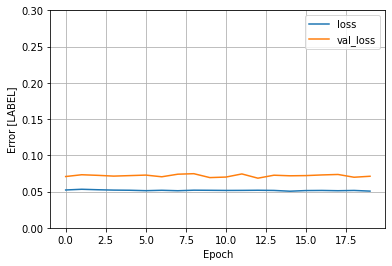

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [LABEL]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

In [ ]:
# This only makes sense for the linear regression model, not the DNN
list(zip(model.layers[1].kernel.numpy().flatten(), train_features.columns))

In [12]:
model.save('models/simple-mcts-score-predictor')

2021-11-07 21:11:18.719768: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/simple-mcts-score-predictor/assets
